# Make a template lightcurve of K2 systematics
as a function of Module, Channel, and Magnitude
then measure how correlated your target of interest is to a template lightcurve of long term K2 systematics

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, savefig
import richardsplot as rplot

from utilities.analysis import pixellc, plotting
from utilities.ccd import CCD
from utilities.containers import *
from utilities.conversions import magToFlux,fluxToMag

/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/astropy/table/np_utils.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _np_utils
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/astropy/io/ascii/fastbasic.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import cparser
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cmap = rplot.palettable.colorbrewer.diverging.PuOr_11.mpl_colormap

In [79]:
cmap = plt.get_cmap('inferno')
mag_colors = np.zeros((len(cmap.colors),4))
mag_colors[:,3] = 0.7 #this is the alpha parameter
mag_colors[:,:3] = cmap.colors

# an HDF5 File with all the pixel data from the campaign is needed
contact jmoreno3663@gmail.com for the files

In [3]:
pixmapfile = "/media/jackeline/UUI/PixelMaps/K2_target_pixels.hdf5"

In [4]:
def create_pixel_map(gen,lc):
    
    ccd = gen.ccd

    #Make the Full Image Map
    fig, ax = subplots(1,1, figsize=(16,9))
    im = plotting.plot_pixel_lc(ax, lc[:,:,2], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
    plotting.format_pixel_image(ax, im, lc.shape[0])
    ax.set_title("Median Pixel Light Curves",
                fontsize=30)
    ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
    ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
    
    #Make the differenced image map
    fig, ax = subplots(1,1, figsize=(16,9))
    im = plotting.plot_pixel_lc(ax, lc[:,:,2], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
    plotting.format_pixel_image(ax, im, lc.shape[0])
    ax.set_title("Differenced Median Pixel Light Curves",
                fontsize=30)
    ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
    ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)


## Single Chanel K2 Intensity Map of Systematics 

In [101]:
ccd = CCD(module=11, channel=3, field='FLUX', campaign=8)
            
cont = PixelMapContainer.from_hdf5(pixmapfile, ccd)
gen = PixMapGenerator(cont)
print "Making", ccd
    
ccd = gen.ccd
flux_range = map(magToFlux,(50,1))
percentiles = np.linspace(0, 100, 300)

lc = pixellc.get_pixel_lc(gen, percentiles, flux_range=flux_range)


Making CCD(module=11, channel=3, field='FLUX', campaign=8)


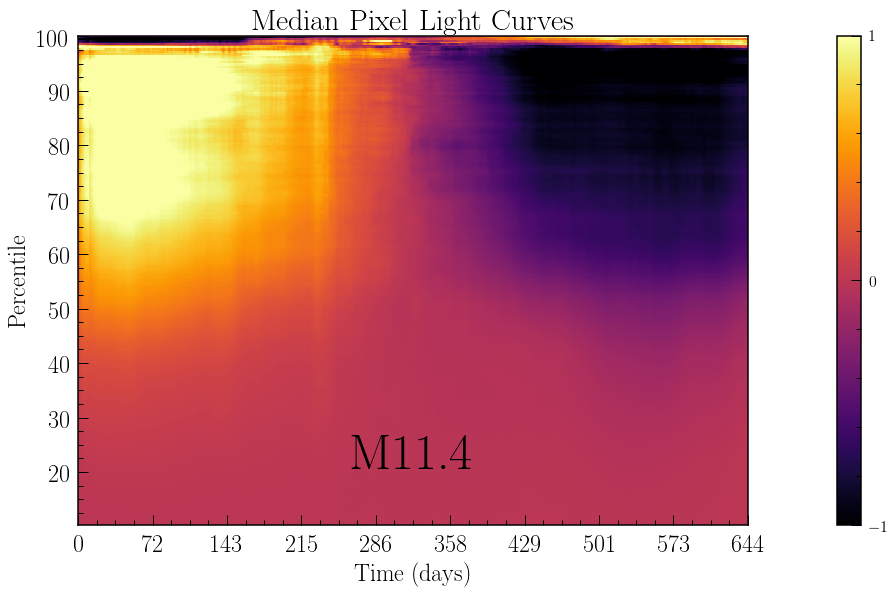

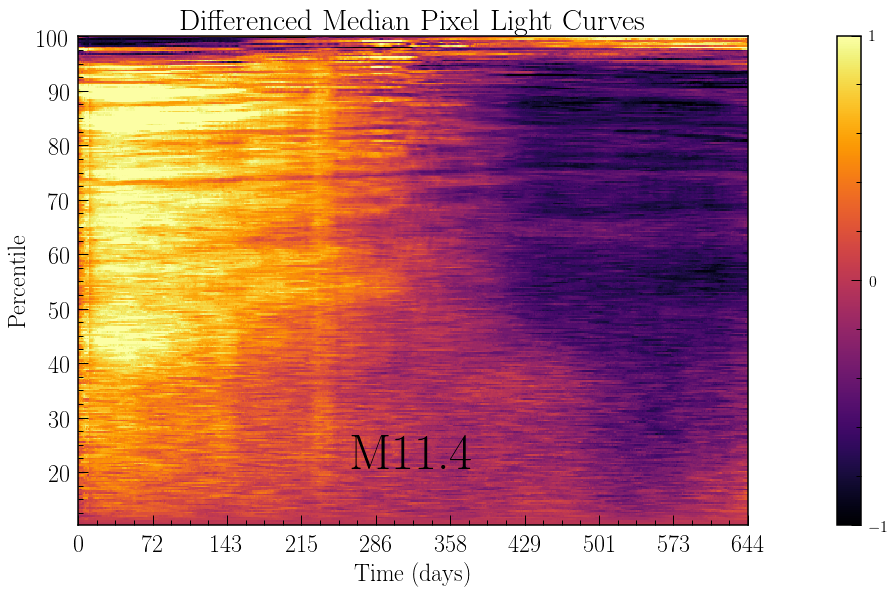

In [102]:
create_pixel_map(gen,lc)

# Flux binned lightcurves

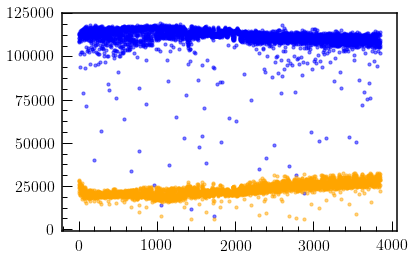

In [103]:
plt.scatter(xrange(len(lc[:,-1,2])),lc[:,-1,2]-lc[:,-2,2],s = 10,color = "blue", alpha = 0.5)
plt.scatter(xrange(len(lc[:,-2,2])),lc[:,-2,2]-lc[:,-3,2],s = 10,color = "orange", alpha = 0.5)

# Smoothing and whitening

In [104]:
from utilities.analysis import plot_template

#look at three examples of smoothing windows
temp1 = plot_template.smooth_template(lc[:,:,2], smooth=150, image=True,differenced=False)
temp2 = plot_template.smooth_template(lc[:,:,2], smooth=500, image=True,differenced=False)
temp3 = plot_template.smooth_template(lc[:,:,2], smooth=1000, image=True,differenced=False)

### Test multiple Smoothing WIndows

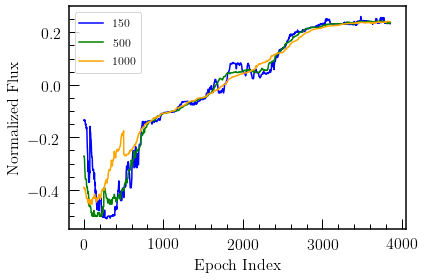

In [105]:
plt.plot(xrange(len(temp1[:,-1])),temp1[:,-1], color = "blue", label = "150")
plt.plot(xrange(len(temp2[:,-1])),temp2[:,-1], color =  "green", label = "500")
plt.plot(xrange(len(temp3[:,-1])),temp3[:,-1], color = "orange", label = "1000")
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()
#plt.savefig('./plots/templateTest.png', dpi = 200)


In [122]:
flux_med_bin_edges = np.nanmedian(lc[:,:,2], axis=0)
mag_med_bin_edges = fluxToMag(flux_med_bin_edges)


## Using minial smoothing for median lightcurve, using aggressive smoothing for differenced lightcurve

In [106]:
temp2_med = plot_template.smooth_template(lc[:,:,2], smooth=10, image=True,differenced=False)
temp2_diff = plot_template.smooth_template(lc[:,:,2], smooth=500, image=True,differenced=True)

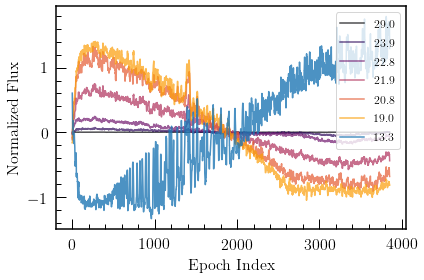

In [120]:
j = 0
for i in range(0,300, 50):
    plt.plot(xrange(len(temp2_med[:,i])),temp2_med[:,i], 
             label = "{:3.1f}".format(mag_med_bin_edges[i]), color =mag_colors[j*40] )
    j +=1
plt.plot(xrange(len(temp2_med[:,-2])),temp2_med[:,-2], label = "{:3.1f}".format(mag_med_bin_edges[-2]), alpha = 0.8) 
    
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()

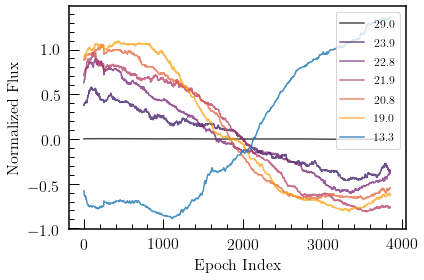

In [121]:
j = 0
for i in range(0,300, 50):
    plt.plot(xrange(len(temp2_diff[:,i])),temp2_diff[:,i], 
              label = "{:3.1f}".format(mag_med_bin_edges[i]), color =mag_colors[j*40] )
    j +=1
plt.plot(xrange(len(temp2_diff[:,-2])),temp2_diff[:,-2], label = "{:3.1f}".format(mag_med_bin_edges[-2]), alpha = 0.8) 
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()

# Testing another channel

In [33]:
ccd = CCD(module=11, channel=2, field='FLUX', campaign=8)
            
cont = PixelMapContainer.from_hdf5(pixmapfile, ccd)
gen = PixMapGenerator(cont)
print "Making", ccd

    
ccd = gen.ccd
flux_range = map(magToFlux,(50,1))
percentiles = np.linspace(0, 100, 500)

lc2 = pixellc.get_pixel_lc(gen, percentiles, flux_range=flux_range)

Making CCD(module=11, channel=2, field='FLUX', campaign=8)


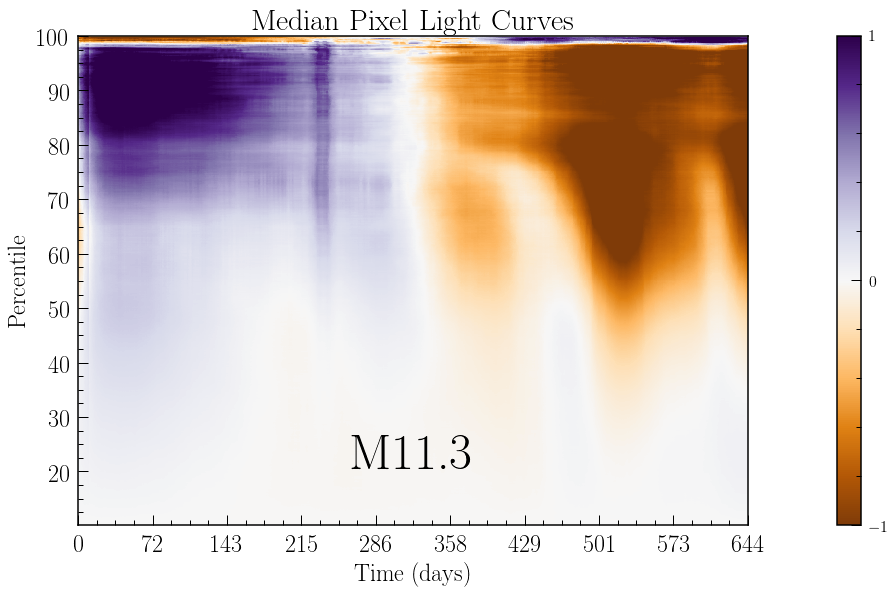

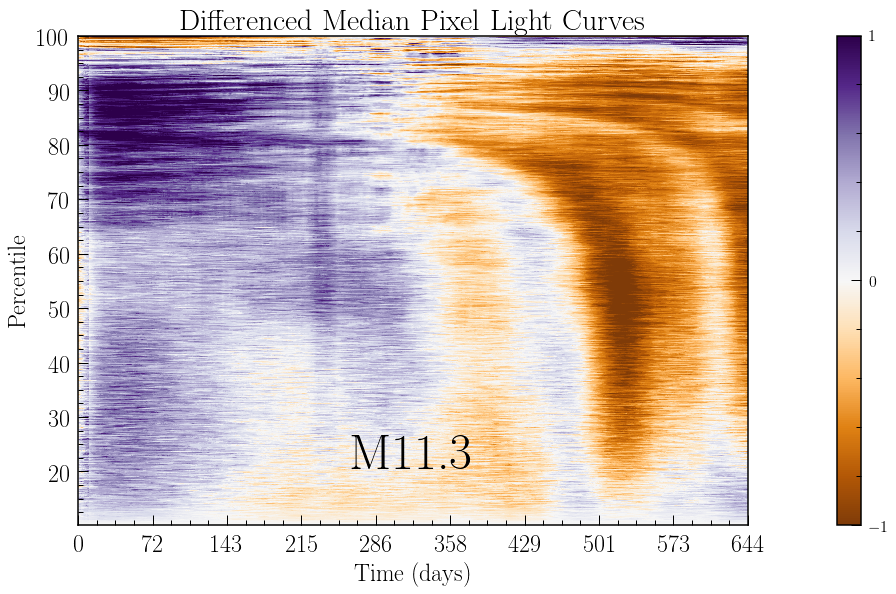

In [34]:
create_pixel_map(gen,lc2)

In [35]:
flux_med_bin_edges = np.nanmedian(lc2[:,:,2], axis=0)
mag_med_bin_edges = fluxToMag(flux_med_bin_edges)

In [36]:
#minimal smoothing (10 cadences)
temp_med_2 = plot_template.smooth_template(lc2[:,:,2], smooth=10, image=True,differenced=False)
temp_med = plot_template.smooth_template(lc2[:,:,2], smooth=500, image=True,differenced=False)
temp_diff = plot_template.smooth_template(lc2[:,:,2], smooth=500, image=True,differenced=True)

### Median lightcurves with aggressive smoothing window

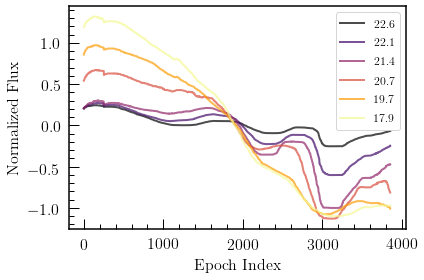

In [94]:
for i in range(200,500,50):
    plt.plot(xrange(len(temp_med[:,i])),temp_med[:,i], 
             label = "{:3.1f}".format(mag_med_bin_edges[i]),lw = 2, color = mag_colors[i-200])
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()

## In these magnitude bin lightcurves we can see variable sources "turn on" in the form of added noise 

compare faintest and brightest magnitude lightcurves, there is visibly more scatter because of astrophysical sources in these pixels rather than background

### Median lightcurves with minimal smoothing

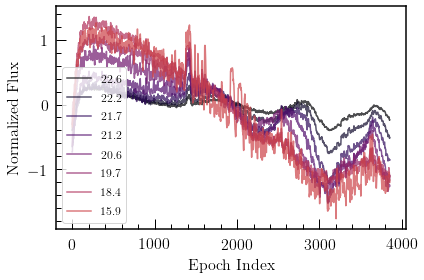

In [100]:
for i in range(200,500,40):
    plt.plot(xrange(len(temp_med_2[:,i])),temp_med_2[:,i], 
             label = "{:3.1f}".format(mag_med_bin_edges[i]),color = mag_colors[(i-200)/2])
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()

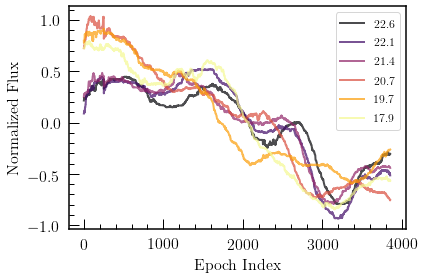

In [93]:
for i in range(200,500,50):
    plt.plot(xrange(len(temp_diff[:,i])),temp_diff[:,i], 
             label = "{:3.1f}".format(mag_med_bin_edges[i]),lw = 2,  color = mag_colors[i-200])
plt.xlabel("Epoch Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.tight_layout()

In [78]:
#np.savetxt("/home/jackeline/Dropbox/Kepler/magbinsC8M11.3.txt", mag_med_bin_edges)
#np.savetxt("/home/jackeline/Dropbox/Kepler/template_diff_lc_C8M11.3.txt", temp_diff)
#np.savetxt("/home/jackeline/Dropbox/Kepler/template_med_lc_C8M11.3.txt", temp_med_2)
